In [21]:
import mediapipe as mp
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def get_landmarks(img_path):
    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh

    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:
        #for idx, file in enumerate(file_list):
        image = cv2.imread(img_path)
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
            raise
        annotated_image = image.copy()
        for face_landmarks in results.multi_face_landmarks:
            #print('face_landmarks:', face_landmarks)
            mp_drawing.draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACE_CONNECTIONS,
              landmark_drawing_spec=drawing_spec,
              connection_drawing_spec=drawing_spec)
        cv2.imwrite('annotated_image' + '.png', annotated_image)
    landmarks = results.multi_face_landmarks[0].landmark
    #landmarks_arr = np.array([[i.x, i.y, i.z] for i in landmarks])
    return landmarks

landmarks = get_landmarks('Images/AF02.jpg')

In [16]:
SEARCH_LIST=[[0,1,2], [0,1,3], [0,2,3], [1,2,3], [0,1,4], [0,2,4], [0,3,4], [1,2,4], [1,3,4], [2,3,4], [0,1,5], [0,2,5], [0,3,5], [0,4,5], [1,2,5], [1,3,5], [1,4,5], [2,3,5], [2,4,5],[3,4,5]]

def is_in_poly(p, poly):
    """
    :param p: [x, y]
    :param poly: [[], [], [], [], ...]
    :return: is_in: boolean. True = p in poly
    """
    px, py = p
    is_in = False
    for i, corner in enumerate(poly):
        next_i = i + 1 if i + 1 < len(poly) else 0
        x1, y1 = corner
        x2, y2 = poly[next_i]
        if (x1 == px and y1 == py) or (x2 == px and y2 == py):  # if point is on vertex
            is_in = True
            break
        if min(y1, y2) < py <= max(y1, y2):  # find horizontal edges of polygon
            x = x1 + (py - y1) * (x2 - x1) / (y2 - y1)
            if x == px:  # if point is on edge
                is_in = True
                break
            elif x > px:  # if point is on left-side of line
                is_in = not is_in
    return is_in

def get_pt_ref(pt, landmarks):
    """
    :params pt: np.array([x, y]), the location of the point 
    :params landmarks: landmark obj
    :return pt_ref: [np.array([x1, x2, x3]), np.array[idx1, idx2, idx3]]
    :return boolean: True = found the correct solution as pt_ref
    """
    landmarks_arr = np.array([[i.x, i.y] for i in landmarks])
    dist = np.linalg.norm(landmarks_arr - pt, axis = 1)
    sorted_idx = np.argsort(dist)
    for search in SEARCH_LIST:
        poly = landmarks_arr[sorted_idx][search]
        if is_in_poly(pt, poly):
            a = np.array([[poly[0,0], poly[1,0], poly[2,0]],[poly[0,1], poly[1,1], poly[2,1]], [1, 1, 1]])
            b = np.array([pt[0], pt[1], 1])
            ans = np.linalg.solve(a,b)
            pt_ref = [ans, sorted_idx[search]]
            return pt_ref, True # Found correct solution
    return [np.array([1, 0, 0]), sorted_idx[[0,1,2]]], False # Solution not found. Return the nearest point

def get_pt_location(pt_ref, landmarks):
    """
    :params pt_ref: [np.array([x1, x2, x3]), np.array[idx1, idx2, idx3]]
    :params landmarks: landmark obj
    :return np.array([x, y, z])
    """
    landmarks_arr = np.array([[i.x, i.y, i.z] for i in landmarks])
    ref_ratio, ref_idx = pt_ref
    return np.dot(landmarks_arr[ref_idx].T, ref_ratio)

pt = np.array([0.59, 0.55])

pt_ref, flag = get_pt_ref(pt, landmarks)
print(pt_ref)
pt_xyz = get_pt_location(pt_ref, landmarks)
print(pt_xyz)

[array([0.08874786, 0.52212875, 0.38912339]), array([465, 417, 351])]
[ 0.59        0.55       -0.06473371]


In [38]:
import json
import pdb
def load_makeup(file_path, landmarks):
    counts = []
    fails = []
    steps = []
    with open(file_path) as fp:
        for line in fp:
            if line.endswith(':\n'):
                step = []
                fail = 0
                count = 0
            elif line == '\n':
                steps.append(step)
                fails.append(fail)
                counts.append(count)
            else:
                #pdb.set_trace()
                x_str, y_str=line.split()
                x = float(x_str)
                y = float(y_str)
                pt = np.array([x, y])
                pt_ref, flag = get_pt_ref(pt, landmarks)
                count += 1
                #if flag:
                #    step.append(pt_ref)
                step.append(pt_ref)
                if not flag:
                    fail += 1
    return steps, counts, fails

file = 'makeup_keypoint.txt'
steps, counts, fails = load_makeup(file, landmarks)

In [39]:
len(steps[0])

32

True

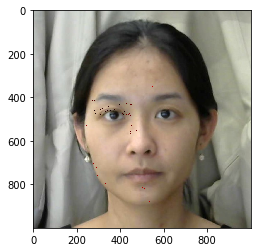

In [45]:

demo_pic = 'Images/AF0.jpg'
landmarks = get_landmarks(demo_pic)
image = cv2.imread(demo_pic)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1000, 1000))
w, h, d = image.shape
step_num = 0
for step in steps:
    step_num += 1
    for pt in step:
        pt_xyz = get_pt_location(pt, landmarks)
        x = int(pt_xyz[0] * w)
        y = int(pt_xyz[1] * h)
        color = ((step_num * 20)%255, 0, 0)
        image = cv2.circle(image, (x,y), radius=1, color=color, thickness=1)
plt.imshow(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imwrite('yushu_with_points_2.jpg', image)